| Name                     | ID       | Specialization |
|--------------------------|----------|----------------|
| هشام حاتم محمد حلمي       | 20220100 | IoT            |


# ASL Sign Language Recognition - Clean Pipeline

This notebook contains all the essential cells needed to:
1. Load and preprocess the dataset
2. Train the ANN model with proper normalization
3. Export the model for mobile deployment

**Important:** Run all cells in order to ensure the model works correctly with the mobile app.

## Cell 1: Install Dependencies

In [ ]:
# Install required packages (run once)
# !pip install pandas numpy scikit-learn torch onnx onnxruntime mediapipe joblib seaborn matplotlib

## Cell 2: Import Libraries

In [3]:
import pandas as pd
import numpy as np
import os
import joblib
import json

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Cell 3: Load Dataset

**Update the path to your dataset file**

In [6]:
# Load dataset - UPDATE THIS PATH!
DATASET_PATH = "dataset.csv"  # Change this to your dataset path

df = pd.read_csv(DATASET_PATH, header=None)

print("Dataset Shape:", df.shape)
print("\nMissing values:", df.isnull().sum().sum())
print("\nLabel Distribution:")
print(df.iloc[:, -1].value_counts())

Dataset Shape: (401, 64)

Missing values: 0

Label Distribution:
63
A    101
B    100
C    100
D    100
Name: count, dtype: int64


## Cell 4: Prepare Features and Labels

In [7]:
# Split features and labels
X = df.iloc[:, :-1]   # 63 landmark features (21 points x 3 coords)
y = df.iloc[:, -1]    # ASL labels

print("Features shape:", X.shape)
print("Labels shape:", y.shape)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\nClasses:", le.classes_)
print("Number of classes:", len(le.classes_))

Features shape: (401, 63)
Labels shape: (401,)

Classes: ['A' 'B' 'C' 'D']
Number of classes: 4


## Cell 5: Landmark Normalization Function

**CRITICAL:** This normalization MUST match exactly what's used in the backend!

In [8]:
def normalize_landmarks_wrist_only(landmarks_array):
    """
    Normalize landmarks relative to wrist position only.
    This is the SAME normalization used in the backend!
    
    Args:
        landmarks_array: numpy array of shape (n_samples, 63)
    
    Returns:
        Normalized landmarks of same shape
    """
    landmarks = landmarks_array.copy()
    
    # Process each sample
    for i in range(len(landmarks)):
        row = landmarks[i]
        # Wrist is at indices 0, 1, 2 (x, y, z of first landmark)
        wrist_x, wrist_y, wrist_z = row[0], row[1], row[2]
        
        # Subtract wrist position from all landmarks
        for j in range(0, 63, 3):
            row[j] -= wrist_x
            row[j + 1] -= wrist_y
            row[j + 2] -= wrist_z
    
    return landmarks

# Apply normalization
X_normalized = normalize_landmarks_wrist_only(X.values)

print("Before normalization:")
print(f"  Min: {X.values.min():.4f}, Max: {X.values.max():.4f}")
print(f"\nAfter wrist-relative normalization:")
print(f"  Min: {X_normalized.min():.4f}, Max: {X_normalized.max():.4f}")

Before normalization:
  Min: -0.1974, Max: 1.0338

After wrist-relative normalization:
  Min: -0.8188, Max: 0.3726


## Cell 6: Train/Test Split

In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (320, 63)
Test size: (81, 63)


## Cell 7: Define ANN Model Architecture

In [10]:
class ASL_ANN(nn.Module):
    """Neural network for ASL classification."""
    
    def __init__(self, input_size, num_classes):
        super(ASL_ANN, self).__init__()
        
        self.network = nn.Sequential(
            # Layer 1
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.4),
            
            # Layer 2
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            
            # Layer 3
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            
            # Output layer
            nn.Linear(64, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.network(x)

# Create model
input_size = X_train.shape[1]  # 63
num_classes = len(le.classes_)

model = ASL_ANN(input_size, num_classes).to(device)

print(f"Model Architecture:")
print(f"  Input size: {input_size}")
print(f"  Output classes: {num_classes}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print()
print(model)

Model Architecture:
  Input size: 63
  Output classes: 4
  Total parameters: 58,692

ASL_ANN(
  (network): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=4, bias=True)
  )
)


## Cell 8: Train the Model

In [11]:
# Prepare tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create validation split from training data
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
)

X_tr_tensor = torch.FloatTensor(X_tr).to(device)
y_tr_tensor = torch.LongTensor(y_tr).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)

# DataLoader
train_dataset = TensorDataset(X_tr_tensor, y_tr_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training settings
epochs = 150
patience = 20
best_loss = float('inf')
patience_counter = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("="*70)
print(f"{'Epoch':<8}{'Train Loss':<14}{'Train Acc':<14}{'Val Loss':<14}{'Val Acc':<14}")
print("="*70)

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    train_loss /= total
    train_acc = correct / total
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
        _, val_predicted = torch.max(val_outputs.data, 1)
        val_acc = (val_predicted == y_val_tensor).sum().item() / len(y_val_tensor)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        best_epoch = epoch + 1
    else:
        patience_counter += 1
    
    # Print progress
    if (epoch + 1) % 10 == 0 or patience_counter == 0:
        marker = "*" if patience_counter == 0 else ""
        print(f"{epoch+1:<8}{train_loss:<14.6f}{train_acc:<14.4f}{val_loss:<14.6f}{val_acc:<14.4f}{marker}")
    
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(best_model_state)
print("="*70)
print(f"Training complete! Best model from epoch {best_epoch}")

Epoch   Train Loss    Train Acc     Val Loss      Val Acc       
1       1.778785      0.2390        1.306613      0.4167        *
2       1.295320      0.4154        1.218308      0.7917        *
3       0.970260      0.5993        1.108188      0.9167        *
4       0.844305      0.6949        0.977434      0.9583        *
5       0.659113      0.7978        0.837902      0.9792        *
6       0.555241      0.8272        0.697314      0.9583        *
7       0.470240      0.8860        0.566764      0.9583        *
8       0.370201      0.9228        0.459870      0.9583        *
9       0.318515      0.9632        0.378700      0.9583        *
10      0.332886      0.9375        0.313763      0.9583        *
11      0.271452      0.9559        0.267967      0.9583        *
12      0.222221      0.9816        0.234195      0.9792        *
13      0.235462      0.9559        0.209324      0.9792        *
14      0.202598      0.9743        0.194009      0.9792        *
15      0.2

## Cell 9: Evaluate Model

Test Accuracy: 1.0000 (100.00%)

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        21
           B       1.00      1.00      1.00        20
           C       1.00      1.00      1.00        20
           D       1.00      1.00      1.00        20

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



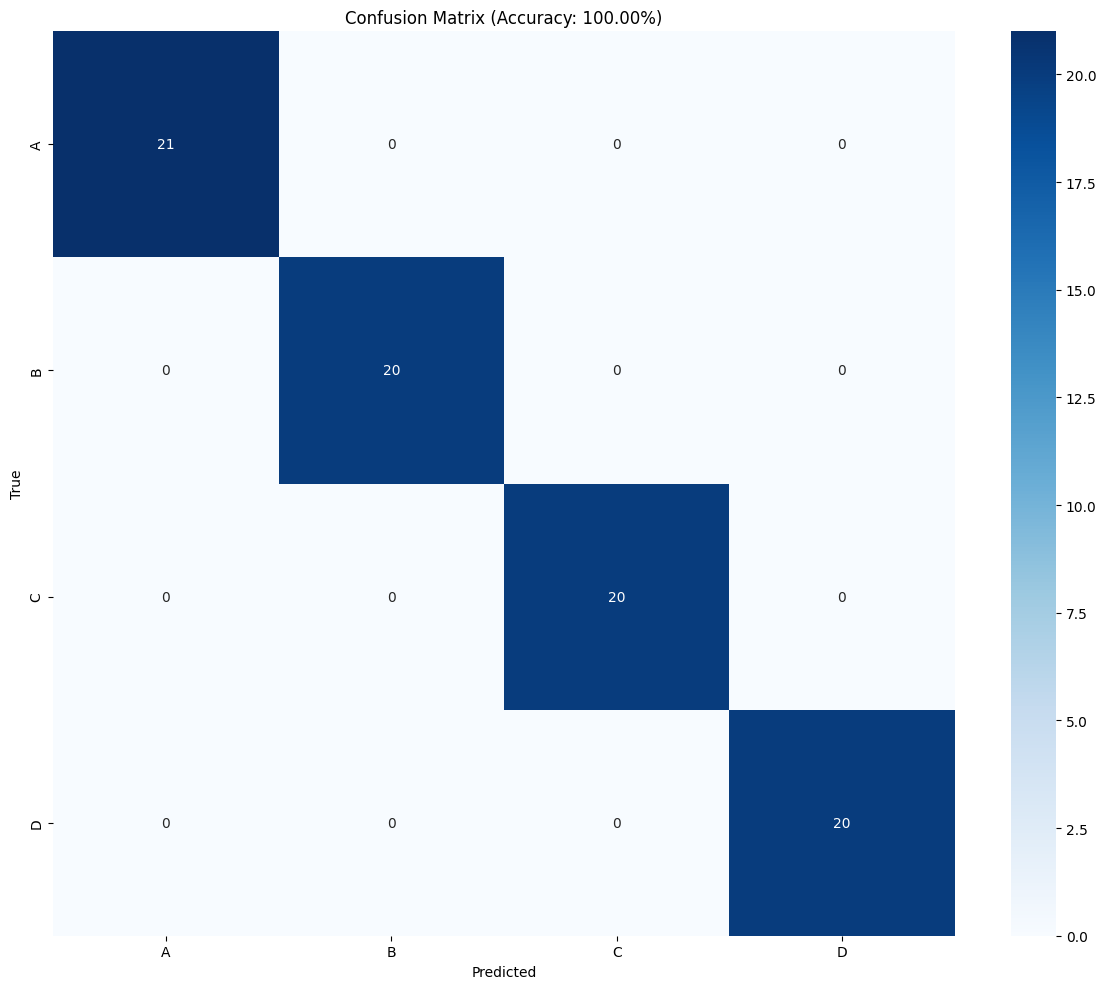

In [8]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predictions = torch.max(outputs, 1)
    predictions = predictions.cpu().numpy()

accuracy = accuracy_score(y_test, predictions)

print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2%})')
plt.tight_layout()
plt.show()

## Cell 10: Training History Visualization

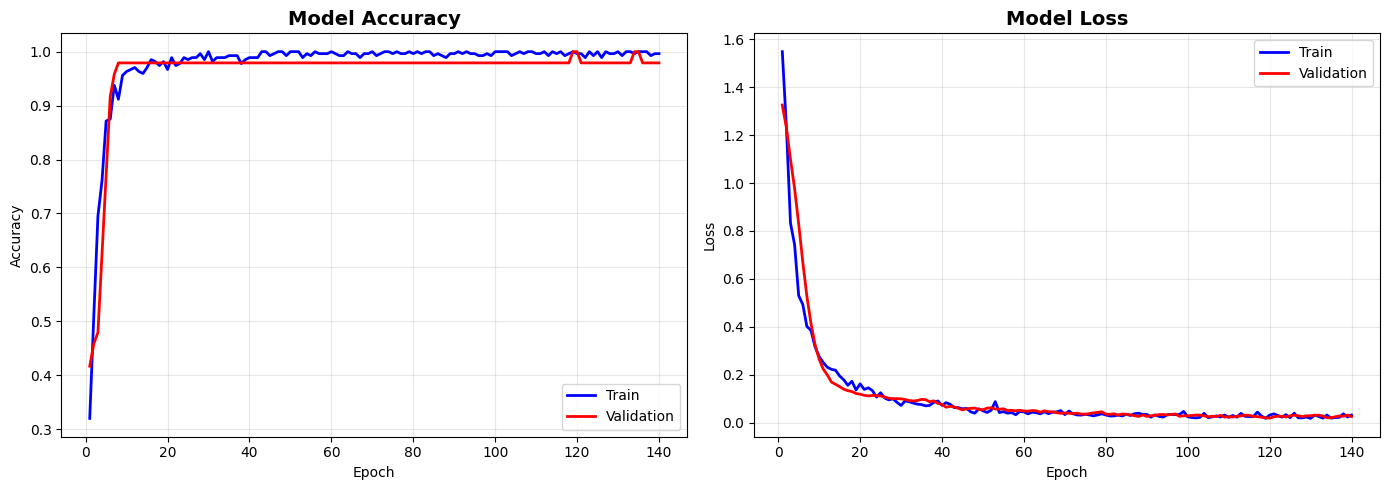

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(history['train_acc']) + 1)

# Accuracy plot
axes[0].plot(epochs_range, history['train_acc'], 'b-', label='Train', linewidth=2)
axes[0].plot(epochs_range, history['val_acc'], 'r-', label='Validation', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(epochs_range, history['train_loss'], 'b-', label='Train', linewidth=2)
axes[1].plot(epochs_range, history['val_loss'], 'r-', label='Validation', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

## Cell 11: Export Model to ONNX for Mobile Deployment

**This exports the model in a format the backend can use**

In [10]:
import onnx

# Set model to evaluation mode
model.eval()

# Create dummy input
dummy_input = torch.randn(1, input_size, device=device)

# Export to ONNX
onnx_path = "asl_model_clean.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=17,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

# Verify the model
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

print(f"ONNX model saved: {onnx_path}")
print(f"Input shape: (batch_size, {input_size})")
print(f"Output shape: (batch_size, {num_classes})")
print(f"Classes: {list(le.classes_)}")

C:\Users\Hesham\AppData\Local\Temp\ipykernel_21900\490824784.py:11: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1222 22:14:31.702000 21900 site-packages\torch\onnx\_internal\exporter\_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 17 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `ASL_ANN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ASL_ANN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 17).


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 3 of general pattern rewrite rules.
ONNX model saved: asl_model_clean.onnx
Input shape: (batch_size, 63)
Output shape: (batch_size, 4)
Classes: ['A', 'B', 'C', 'D']


## Cell 12: Save Label Encoder

In [11]:
# Save label encoder for the backend
joblib.dump(le, "asl_label_encoder.pkl")

# Also save as JSON for easy reference
label_mapping = {
    'classes': list(le.classes_),
    'index_to_label': {i: label for i, label in enumerate(le.classes_)}
}

with open('label_mapping.json', 'w') as f:
    json.dump(label_mapping, f, indent=2)

print("Label encoder saved: asl_label_encoder.pkl")
print("Label mapping saved: label_mapping.json")
print(f"\nClasses: {le.classes_}")

Label encoder saved: asl_label_encoder.pkl
Label mapping saved: label_mapping.json

Classes: ['A' 'B' 'C' 'D']


## Cell 13: Verify ONNX Model Works

**Test that the exported ONNX model produces the same predictions as PyTorch**

In [12]:
import onnxruntime as ort

# Load ONNX model
ort_session = ort.InferenceSession(onnx_path)

# Test with a few samples
test_samples = X_test[:10]

# ONNX predictions
onnx_outputs = ort_session.run(None, {'input': test_samples.astype(np.float32)})
onnx_preds = np.argmax(onnx_outputs[0], axis=1)

# PyTorch predictions
model.eval()
with torch.no_grad():
    torch_outputs = model(torch.FloatTensor(test_samples).to(device))
    torch_preds = torch.argmax(torch_outputs, dim=1).cpu().numpy()

print("ONNX Model Verification:")
print(f"  PyTorch predictions: {torch_preds}")
print(f"  ONNX predictions:    {onnx_preds}")
print(f"  Match: {np.array_equal(torch_preds, onnx_preds)}")

# Convert to letters
print(f"\n  Predicted letters: {[le.classes_[i] for i in onnx_preds]}")
print(f"  True letters:      {[le.classes_[i] for i in y_test[:10]]}")

ONNX Model Verification:
  PyTorch predictions: [2 1 0 0 2 0 3 1 2 0]
  ONNX predictions:    [2 1 0 0 2 0 3 1 2 0]
  Match: True

  Predicted letters: ['C', 'B', 'A', 'A', 'C', 'A', 'D', 'B', 'C', 'A']
  True letters:      ['C', 'B', 'A', 'A', 'C', 'A', 'D', 'B', 'C', 'A']


## Cell 14: Copy Files to Backend

**Run this to copy the model files to the backend folder**

In [13]:
import shutil

# Files to copy
files_to_copy = [
    'asl_model_clean.onnx',
    'asl_label_encoder.pkl'
]

# Copy to parent directory (where backend expects them)
for file in files_to_copy:
    if os.path.exists(file):
        # Copy to current directory (project root)
        print(f"Model file ready: {file}")
    else:
        print(f"Warning: {file} not found!")

print("\n" + "="*60)
print("DEPLOYMENT INSTRUCTIONS:")
print("="*60)
print("""
1. Copy 'asl_model_clean.onnx' to your project root folder

2. Update backend/main.py to use the new model:
   classifier = SignClassifier(
       "../asl_model_clean.onnx",
       "../asl_label_encoder.pkl"
   )

3. Restart the backend server:
   cd backend
   uvicorn main:app --host 0.0.0.0 --port 8000

4. Test with the mobile app!
""")

Model file ready: asl_model_clean.onnx
Model file ready: asl_label_encoder.pkl

DEPLOYMENT INSTRUCTIONS:

1. Copy 'asl_model_clean.onnx' to your project root folder

2. Update backend/main.py to use the new model:
   classifier = SignClassifier(
       "../asl_model_clean.onnx",
       "../asl_label_encoder.pkl"
   )

3. Restart the backend server:
   cd backend
   uvicorn main:app --host 0.0.0.0 --port 8000

4. Test with the mobile app!



## Cell 15: Live Camera Test (Optional)

**Test the model with your webcam to verify it works before deploying to mobile**

In [16]:
# Uncomment to run live camera test

import cv2
import mediapipe as mp

mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.7
)

# Load ONNX model
ort_session = ort.InferenceSession("asl_model_clean.onnx")

cap = cv2.VideoCapture(0)

def normalize_for_inference(landmarks):
    """Normalize landmarks the same way as training."""
    landmarks = np.array(landmarks, dtype=np.float32)
    wrist_x, wrist_y, wrist_z = landmarks[0], landmarks[1], landmarks[2]
    
    for i in range(0, 63, 3):
        landmarks[i] -= wrist_x
        landmarks[i + 1] -= wrist_y
        landmarks[i + 2] -= wrist_z
    
    return landmarks.reshape(1, -1)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(rgb)
    
    if result.multi_hand_landmarks:
        hand = result.multi_hand_landmarks[0]
        mp_draw.draw_landmarks(frame, hand, mp_hands.HAND_CONNECTIONS)
        
        # Extract landmarks
        landmarks = []
        for lm in hand.landmark:
            landmarks.extend([lm.x, lm.y, lm.z])
        
        # Normalize and predict
        features = normalize_for_inference(landmarks)
        outputs = ort_session.run(None, {'input': features})
        
        # Get prediction with softmax
        logits = outputs[0][0]
        exp_logits = np.exp(logits - np.max(logits))
        probs = exp_logits / exp_logits.sum()
        
        pred_idx = np.argmax(probs)
        confidence = probs[pred_idx]
        letter = le.classes_[pred_idx]
        
        color = (0, 255, 0) if confidence > 0.7 else (0, 165, 255)
        cv2.putText(frame, f"{letter} ({confidence:.0%})", (30, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3)
    
    cv2.imshow("ASL Recognition Test", frame)
    
    if cv2.waitKey(1) & 0xFF == 27:  # ESC to quit
        break

cap.release()
cv2.destroyAllWindows()


print("Live camera test code is available - uncomment to run")

Live camera test code is available - uncomment to run
